In [1]:
import argparse
from datetime import datetime, date
from uti import DataLoader, Logger
from Database import GSDatabase, GSPriceDf
import re
from Model.settings import DataCleaner
import pandas as pd
import numpy as np
from datetime import datetime, date

GSD = GSDatabase()
logger = Logger()
DL = DataLoader()
DC = DataCleaner()

\
Current root directory: C:/Users/JayYang/OneDrive - Alpha Sherpa Capital
Current Base directory: C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi
Current Database directory: C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database


2022-05-13 16:44:18,069 P[18632] [MainThread 12224] Error: no proxy address identified.
Check if Eikon Desktop or Eikon API Proxy is running.
2022-05-13 16:44:18,071 P[18632] [MainThread 12224] Error on handshake url http://127.0.0.1:None/api/handshake : UnsupportedProtocol("Request URL is missing an 'http://' or 'https://' protocol.")
2022-05-13 16:44:18,072 P[18632] [MainThread 12224] Error on handshake url http://127.0.0.1:None/api/handshake : UnsupportedProtocol("Request URL is missing an 'http://' or 'https://' protocol.")
2022-05-13 16:44:18,073 P[18632] [MainThread 12224] Port number was not identified, cannot send any request


Current working directory C:\Users\JayYang\Platform\Citi
16:44:19 C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Log/20220513/20220513164418.txt created.
16:44:19 Engine current settings: 
daily_position 18 
region_position 6 
skewness: 0
16:44:19 Engine current settings: 
daily_position 18 
region_position 6 
skewness: 0


In [2]:
"""
1. Get train data before march, used as the scoring training data on reports after march

2. Pull the reports after march, 
- Apply before march scoring on march reports
- Apply before april scoring on april reports
- Apply scoring for Goldman and Citi

3. From "Jay pnl for benchmark.csv", calculate the number of longs/shorts on each day; real trades pnl, times ATR(x) to reach the 
pnl as is the case where ATR(x)=1 is used in system calculation

4. Select trades from Goldman/Citi based on daily numbers of shorts/longs
Three cases to consider
- Wholly Goldman
- Wholly Citi
- Randomly from Goldman/Citi

"""

'\n1. Get train data before march, used as the scoring training data on reports after march\n\n2. Pull the reports after march, \n- Apply before march scoring on march reports\n- Apply before april scoring on april reports\n- Apply scoring for Goldman and Citi\n\n3. From "Jay pnl for benchmark.csv", calculate the number of longs/shorts on each day; real trades pnl, times ATR(x) to reach the \npnl as is the case where ATR(x)=1 is used in system calculation\n\n4. Select trades from Goldman/Citi based on daily numbers of shorts/longs\nThree cases to consider\n- Wholly Goldman\n- Wholly Citi\n- Randomly from Goldman/Citi\n\n'

In [3]:
train_data, test_data = DC.get_benchmark_test_data()

16:44:19 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Backtest/Benchmark data/X_train.csv
16:44:20 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Backtest/Benchmark data/X_test.csv


In [4]:
all_data = pd.concat([train_data, test_data], axis=0)

In [5]:
from Model.rules import benchmark_rule, benchmark_rule2, benchmark_rule3
from Model.benchmark import get_daily_trade
from Model.LR import LR

In [6]:
# Get Citi Reports with scores for March

In [7]:
train_data = all_data[all_data['Date'] < datetime(2022, 3, 1)].copy()
test_data = all_data[(all_data['Date'] >= datetime(2022, 3, 1)) & (all_data['Date'] < datetime(2022, 5, 1))].copy()
test_data

,Time,Summary,Date,Ticker,Tickers,company,Headline,Region,Industry,Head analyst,...,release_period,ticker_updated,gap_in_atr,exch_region2,market_cap_grp,side,stop_loss,d0_r,d1_r,d2_r
12574,2022-03-01 14:54:00,"Macau's Feb-22 GGR came in at MOP7,759m (or ~M...",2022-03-01,0027.HK,"0027.HK,LVS,0200.HK,MLCO,2282.HK,MGM,1928.HK,0...",Galaxy Entertainment,"Macau Gaming: Feb-22 GGR MOP7,759m; ~31% of Fe...",HK,Casinos & Gaming,"George Choi, CFA",...,Within,0027.HK HK,-0.023185,Asia,LargeCap,short,45.556536,-0.510077,-0.301409,-1.298378
12575,2022-03-01 15:46:00,We expect Veeva to deliver a solid close to FY...,2022-03-01,VEEV,VEEV,Veeva Systems Inc,Veeva Systems Inc (VEEV.N): Looking to bounce ...,US,Application Software,Tyler Radke,...,Before,VEEV US,-0.040546,Americas,LargeCap,short,237.228514,-0.500072,-0.362021,3.254328
12576,2022-03-01 15:36:00,Gamuda's consortium has been awarded the contr...,2022-03-01,GAMU.KL,GAMU.KL,Gamuda,Gamuda (GAMU.KL): Second win for the year: A$2...,MK,Engineering & Construction,Wai Hoong Liew,...,Within,GAMU.KL MK,0.257959,Asia,SmallCap,long,2.812468,2.708566,4.256318,4.514276
12577,2022-03-01 15:29:00,The #1 question we get asked by investors on t...,2022-03-01,LLOY.L,"LLOY.L,UBSG.S,SOGN.PA,ABNd.AS,DBKGn.DE,SWEDa.ST",Lloyds Banking Group PLC,WATCH: European Diversified Banks and Regional...,LN,Diversified Banks,"Andrew Coombs, CFA",...,Before,LLOY.L LN,-0.783266,Europe,LargeCap,short,51.212465,1.021409,0.911640,1.253970
12578,2022-03-01 15:27:00,"Q4 loss/FCF burn better than our model, but th...",2022-03-01,LCID,LCID,Lucid Group Inc,Lucid Group Inc (LCID.O): Q4 Takeaways; Loweri...,US,Automobile Manufacturers,Itay Michaeli,...,Before,LCID US,0.153082,Americas,LargeCap,short,27.032653,-0.198222,-0.037289,0.728121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15379,2022-04-29 00:52:00,We hosted BBMG's 1Q22 post-results conference ...,2022-04-29,2009.HK,"2009.HK,601992.SS",BBMG,BBMG (2009.HK): Transcript: 1Q22 Post-Results ...,HK,Engineering & Construction,"Jack Shang, CFA",...,Before,2009.HK HK,-0.238891,Asia,MidCap,short,1.291860,-0.716672,0.000000,0.000000
15380,2022-04-29 00:45:00,"1Q22 net profit of ENN Natural Gas (""ENN NG"") ...",2022-04-29,600803.SS,600803.SS,ENN Natural Gas,ENN Natural Gas (600803.SS): Strong Profit Gro...,CH,Gas Utilities,"Pierre Lau, CFA",...,Before,600803.SS CH,-0.179640,Asia,MidCap,long,15.330663,0.359280,0.000000,0.000000
15381,2022-04-29 00:43:00,"Baosteel reported its 2021 NI at Rmb23.6bn, up...",2022-04-29,600019.SS,600019.SS,Baoshan Iron & Steel,Baoshan Iron &amp; Steel (600019.SS): 1Q22 NI ...,CH,Steel,"Jack Shang, CFA",...,Before,600019.SS CH,-0.189596,Asia,LargeCap,short,6.493719,-0.872141,0.000000,0.000000
15382,2022-04-29 00:20:00,"COSL net profit came in at Rmb304m, up 68% yoy...",2022-04-29,2883.HK,2883.HK,China Oilfield Services,China Oilfield Services (2883.HK): Earnings Se...,HK,Oil & Gas Equipment & Services,Toby Shek,...,Before,2883.HK HK,0.185009,Asia,MidCap,long,7.381639,0.766464,0.000000,0.000000


In [8]:
test_data['side'] = benchmark_rule(test_data)
test_data['side'] = benchmark_rule2(test_data)
test_data['side'] = benchmark_rule3(test_data)
train_data, test_data, elements_name = get_daily_trade(train_data, test_data)  # Calculate factor scores

model = LR(train_data[elements_name], train_data[['d0_r']])
model.train()
model.evaluate()
intercept, ols_weights = model.get_params()

# Scoring: in Americas use OLS, in Asia and Europe use simple average.
us_mask = (test_data['exch_region'] == 'Americas')
test_data['ols_score'] = np.sum(ols_weights * test_data[elements_name], axis=1) + intercept[0]
test_data['mean_score'] = np.mean(test_data[elements_name], axis=1)
test_data['score'] = np.where(us_mask, test_data['ols_score'], test_data['mean_score'])
test_data.loc[test_data['score'] <= 0, 'side'] = ''
test_data.loc[test_data['score'] <= 0, 'score'] = 0
test_data.loc[~test_data['side'].isin(['long', 'short']), 'score'] = 0

test_data['d0_exp'] = np.where(us_mask, test_data['ols_score'], test_data['mean_score'])

Head analyst_score
['Head analyst_score']
Ticker_score
['Head analyst_score', 'Ticker_score']
release_period_score
['Head analyst_score', 'Ticker_score', 'release_period_score']
Report Type_score
['Head analyst_score', 'Ticker_score', 'release_period_score', 'Report Type_score']
Intercept: [-0.07894801]
Coefficients: [[0.20056853 0.97149182 0.7914407  0.7432175 ]]
Score:  0.055885939678842256
R2 score:  0.055885939678842256
MSE score:  0.6927523518254863
RMSE score:  0.8323174585610267
                            OLS Regression Results                            
Dep. Variable:                   d0_r   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     870.0
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        16:45:07   Log-Likelihood:                -72639.
No. Observations:               587

C:\Users\JayYang\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [9]:
test_data['pm_region'] = test_data['exch_region']

In [10]:
qr_df = test_data[test_data['Report Type'] == 'Earnings Review']

In [ ]:
# Get Citi Reports with scores for April

<AxesSubplot:>

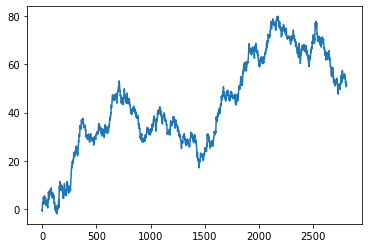

In [12]:
test_data['d0_r'].cumsum().plot()

In [28]:
# asia_df = test_data[test_data['exch_region'] == 'Asia'].reset_index(drop=True).copy()
asia_df = test_data[test_data['exch_region'] == 'Asia'].reset_index(drop=True).copy()
# eu_df = test_data[test_data['exch_region'] == 'Europe'].reset_index(drop=True).copy()
# asia_df = test_data[test_data['exch_region'] == 'Europe'].reset_index(drop=True).copy()
# am_df = test_data[test_data['exch_region'] == 'Americas'].reset_index(drop=True).copy()

# asia_qr_df = qr_df[qr_df['exch_region'] == 'Asia'].reset_index(drop=True).copy()
asia_qr_df = qr_df[qr_df['exch_region'] == 'Asia'].reset_index(drop=True).copy()
# eu_qr_df = qr_df[qr_df['exch_region'] == 'Europe'].reset_index(drop=True).copy()
# asia_qr_df = qr_df[qr_df['exch_region'] == 'Europe'].reset_index(drop=True).copy()
# am_qr_df = qr_df[qr_df['exch_region'] == 'Americas'].reset_index(drop=True).copy()

<AxesSubplot:>

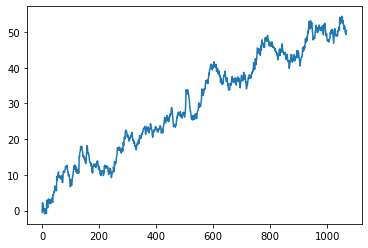

In [29]:
asia_df['d0_r'].cumsum().plot()

<AxesSubplot:>

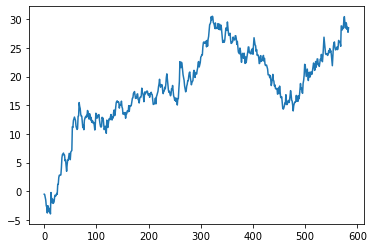

In [30]:
asia_qr_df['d0_r'].cumsum().plot()

In [31]:
asia_df

,Time,Summary,Date,Ticker,Tickers,company,Headline,Region,Industry,Head analyst,...,d2_r,Head analyst_score,Ticker_score,release_period_score,Report Type_score,score,ols_score,mean_score,d0_exp,pm_region
0,2022-03-01 14:54:00,"Macau's Feb-22 GGR came in at MOP7,759m (or ~M...",2022-03-01,0027.HK,"0027.HK,LVS,0200.HK,MLCO,2282.HK,MGM,1928.HK,0...",Galaxy Entertainment,"Macau Gaming: Feb-22 GGR MOP7,759m; ~31% of Fe...",HK,Casinos & Gaming,"George Choi, CFA",...,-1.298378,0.025998,-0.060850,0.081719,0.062248,0.027279,-0.021910,0.027279,0.027279,Asia
1,2022-03-01 15:36:00,Gamuda's consortium has been awarded the contr...,2022-03-01,GAMU.KL,GAMU.KL,Gamuda,Gamuda (GAMU.KL): Second win for the year: A$2...,MK,Engineering & Construction,Wai Hoong Liew,...,4.514276,0.010971,0.149406,0.081719,0.030565,0.068165,0.155791,0.068165,0.068165,Asia
2,2022-03-01 14:00:00,The shares of both Ibiden and Shinko have been...,2022-03-01,4062,"40,626,967",Ibiden,Japan Electronic Components: Our take on the p...,JP,Electronic Components & Equipment,Takayuki Naito,...,0.000000,-0.044302,-0.067626,0.081719,0.062248,0.008010,-0.042592,0.008010,0.008010,Asia
3,2022-03-01 14:00:00,"We raise our target price to ¥2,200 to reflect...",2022-03-01,5334.T,5334,NGK Spark Plug,NGK Spark Plug (5334.T): Staying Neutral &ndas...,JP,Auto Parts & Equipment,Takayuki Naito,...,-1.000000,-0.044302,-0.144007,0.081719,0.062248,0.000000,-0.116795,-0.011085,-0.011085,Asia
4,2022-03-01 16:19:00,Upgrade to Buy (from Neutral): TP RM5.00 (from...,2022-03-01,PUBM.KL,PUBM.KL,Public Bank,Public Bank (PUBM.KL): Upgrade to Buy: Defensi...,MK,Diversified Banks,"Robert Kong, CFA",...,-0.274044,0.114261,0.013921,0.081719,0.062248,0.068037,0.068433,0.068037,0.068037,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064,2022-04-29 00:52:00,We hosted BBMG's 1Q22 post-results conference ...,2022-04-29,2009.HK,"2009.HK,601992.SS",BBMG,BBMG (2009.HK): Transcript: 1Q22 Post-Results ...,HK,Engineering & Construction,"Jack Shang, CFA",...,0.000000,0.099280,0.588057,0.041173,0.030565,0.189769,0.567560,0.189769,0.189769,Asia
1065,2022-04-29 00:45:00,"1Q22 net profit of ENN Natural Gas (""ENN NG"") ...",2022-04-29,600803.SS,600803.SS,ENN Natural Gas,ENN Natural Gas (600803.SS): Strong Profit Gro...,CH,Gas Utilities,"Pierre Lau, CFA",...,0.000000,0.129958,0.000000,0.041173,0.062248,0.058345,0.025967,0.058345,0.058345,Asia
1066,2022-04-29 00:43:00,"Baosteel reported its 2021 NI at Rmb23.6bn, up...",2022-04-29,600019.SS,600019.SS,Baoshan Iron & Steel,Baoshan Iron &amp; Steel (600019.SS): 1Q22 NI ...,CH,Steel,"Jack Shang, CFA",...,0.000000,0.099280,0.000000,0.041173,0.062248,0.050675,0.019814,0.050675,0.050675,Asia
1067,2022-04-29 00:20:00,"COSL net profit came in at Rmb304m, up 68% yoy...",2022-04-29,2883.HK,2883.HK,China Oilfield Services,China Oilfield Services (2883.HK): Earnings Se...,HK,Oil & Gas Equipment & Services,Toby Shek,...,0.000000,0.422217,0.000000,0.041173,0.062248,0.131409,0.084585,0.131409,0.131409,Asia


In [17]:
from Backtest import BacktestEngine, visual

In [18]:
BE = BacktestEngine()

16:45:16 Engine current settings: 
daily_position 18 
region_position 6 
skewness: 0


In [32]:
strat = 'Asia all 2 trades'
BE._daily_position = 2
BE._region_position = 2
pnl_all_2 = BE.portfolio_management(asia_df, rank_by='d0_exp')
DL.toBT(pnl_all_2, strat)

vis = visual(strat)
vis.visual_job()

16:55:32 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Backtest/Asia all 2 trades.csv
side 
long     46
short    46
dtype: int64
 Sum of d0_r 2.785688821878441
 Sum of d1_r 11.828189552325581
 Sum of d2_r 8.912860406881052
Asia Sum of d0_r 2.785688821878441
Asia Sum of d1_r 11.828189552325581
Asia Sum of d2_r 8.912860406881052
Asia Sum of d0_r 2.785688821878441
Asia Sum of d1_r 11.828189552325581
Asia Sum of d2_r 8.912860406881052

Total hit ratio d0_r 0.4891304347826087
Long trades hit ratio d0_r 0.5217
Short trades hit ratio d0_r 0.4565

Total expectancy: 0.030279226324765596
side
long     0.036835
short    0.023723
Name: Expectancy, dtype: float64

Total hit ratio d1_r 0.5
Long trades hit ratio d1_r 0.4565
Short trades hit ratio d1_r 0.5435

Total expectancy: 0.1285672777426693
side
long     0.022879
short    0.234255
Name: Expectancy, dtype: float64



In [33]:
strat = 'Asia all 4 trades'
BE._daily_position = 4
BE._region_position = 4
pnl_all_4 = BE.portfolio_management(asia_df, rank_by='d0_exp')
DL.toBT(pnl_all_4, strat)

vis = visual(strat)
vis.visual_job()

16:55:38 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Backtest/Asia all 4 trades.csv
side 
long     89
short    89
dtype: int64
 Sum of d0_r 12.313771123275941
 Sum of d1_r 33.27710269785023
 Sum of d2_r 29.932214876409724
Asia Sum of d0_r 12.313771123275941
Asia Sum of d1_r 33.27710269785023
Asia Sum of d2_r 29.932214876409724
Asia Sum of d0_r 12.313771123275941
Asia Sum of d1_r 33.27710269785023
Asia Sum of d2_r 29.932214876409724

Total hit ratio d0_r 0.5056179775280899
Long trades hit ratio d0_r 0.4944
Short trades hit ratio d0_r 0.5169

Total expectancy: 0.06917848945660629
side
long     0.087999
short    0.050358
Name: Expectancy, dtype: float64

Total hit ratio d1_r 0.5449438202247191
Long trades hit ratio d1_r 0.5056
Short trades hit ratio d1_r 0.5843

Total expectancy: 0.1869500151564621
side
long     0.124006
short    0.249894
Name: Expectancy, dtype: float64



In [35]:
strat = 'Asia all 6 trades'
BE._region_position = 6
BE._daily_position = 6
pnl_all_6 = BE.portfolio_management(asia_df, rank_by='d0_exp')
DL.toBT(pnl_all_6, strat)

vis = visual(strat)
vis.visual_job()

16:55:50 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Backtest/Asia all 6 trades.csv
side 
long     124
short    124
dtype: int64
 Sum of d0_r 5.297238866690559
 Sum of d1_r 23.14804785987307
 Sum of d2_r 19.88719492121333
Asia Sum of d0_r 5.297238866690559
Asia Sum of d1_r 23.14804785987307
Asia Sum of d2_r 19.88719492121333
Asia Sum of d0_r 5.297238866690559
Asia Sum of d1_r 23.14804785987307
Asia Sum of d2_r 19.88719492121333

Total hit ratio d0_r 0.47580645161290325
Long trades hit ratio d0_r 0.4516
Short trades hit ratio d0_r 0.5000

Total expectancy: 0.021359834139881295
side
long    -0.016368
short    0.059088
Name: Expectancy, dtype: float64

Total hit ratio d1_r 0.5
Long trades hit ratio d1_r 0.4677
Short trades hit ratio d1_r 0.5323

Total expectancy: 0.0933389026607786
side
long     0.015394
short    0.171283
Name: Expectancy, dtype: float64



In [34]:
strat = 'Asia all 8 trades'
BE._region_position = 8
BE._daily_position = 8
pnl_all_8 = BE.portfolio_management(asia_df, rank_by='d0_exp')
DL.toBT(pnl_all_8, strat)

vis = visual(strat)
vis.visual_job()

16:55:44 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Backtest/Asia all 8 trades.csv
side 
long     155
short    155
dtype: int64
 Sum of d0_r 3.5279387379623754
 Sum of d1_r 22.068290369558273
 Sum of d2_r 24.823753671007466
Asia Sum of d0_r 3.5279387379623754
Asia Sum of d1_r 22.068290369558273
Asia Sum of d2_r 24.823753671007466
Asia Sum of d0_r 3.5279387379623754
Asia Sum of d1_r 22.068290369558273
Asia Sum of d2_r 24.823753671007466

Total hit ratio d0_r 0.4645161290322581
Long trades hit ratio d0_r 0.4452
Short trades hit ratio d0_r 0.4839

Total expectancy: 0.011380447541813998
side
long     0.014557
short    0.008204
Name: Expectancy, dtype: float64

Total hit ratio d1_r 0.4838709677419355
Long trades hit ratio d1_r 0.4774
Short trades hit ratio d1_r 0.4903

Total expectancy: 0.0711880334501882
side
long     0.065878
short    0.076498
Name: Expectancy, dtype: float64



In [36]:
strat = 'Asia qr 2 trades'
BE._region_position = 2
BE._daily_position = 2
pnl_qr_2 = BE.portfolio_management(asia_qr_df, rank_by='d0_exp')
DL.toBT(pnl_qr_2, strat)

vis = visual(strat)
vis.visual_job()

16:55:56 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Backtest/Asia qr 2 trades.csv
side 
long     39
short    39
dtype: int64
 Sum of d0_r 8.248273913731241
 Sum of d1_r 10.494300704211462
 Sum of d2_r 12.307929366727283
Asia Sum of d0_r 8.248273913731241
Asia Sum of d1_r 10.494300704211462
Asia Sum of d2_r 12.307929366727283
Asia Sum of d0_r 8.248273913731241
Asia Sum of d1_r 10.494300704211462
Asia Sum of d2_r 12.307929366727283

Total hit ratio d0_r 0.5512820512820513
Long trades hit ratio d0_r 0.5641
Short trades hit ratio d0_r 0.5385

Total expectancy: 0.10574710145809285
side
long     0.121896
short    0.089599
Name: Expectancy, dtype: float64

Total hit ratio d1_r 0.5256410256410257
Long trades hit ratio d1_r 0.4872
Short trades hit ratio d1_r 0.5641

Total expectancy: 0.1345423167206597
side
long     0.123436
short    0.145648
Name: Expectancy, dtype: float64



In [37]:
strat = 'Asia qr 4 trades'
BE._region_position = 4
BE._daily_position = 4
pnl_qr_4 = BE.portfolio_management(asia_qr_df, rank_by='d0_exp')
DL.toBT(pnl_qr_4, strat)

vis = visual(strat)
vis.visual_job()

16:55:59 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Backtest/Asia qr 4 trades.csv
side 
long     69
short    69
dtype: int64
 Sum of d0_r 4.1902988625767925
 Sum of d1_r 14.766773589365917
 Sum of d2_r 12.592292182226092
Asia Sum of d0_r 4.1902988625767925
Asia Sum of d1_r 14.766773589365917
Asia Sum of d2_r 12.592292182226092
Asia Sum of d0_r 4.1902988625767925
Asia Sum of d1_r 14.766773589365917
Asia Sum of d2_r 12.592292182226092

Total hit ratio d0_r 0.4782608695652174
Long trades hit ratio d0_r 0.5072
Short trades hit ratio d0_r 0.4493

Total expectancy: 0.030364484511425982
side
long     0.062764
short   -0.002035
Name: Expectancy, dtype: float64

Total hit ratio d1_r 0.4782608695652174
Long trades hit ratio d1_r 0.5217
Short trades hit ratio d1_r 0.4348

Total expectancy: 0.10700560572004292
side
long     0.208032
short    0.005980
Name: Expectancy, dtype: float64



In [38]:
strat = 'Asia qr 6 trades'
BE._region_position = 6
BE._daily_position = 6
pnl_qr_6 = BE.portfolio_management(asia_qr_df, rank_by='d0_exp')
DL.toBT(pnl_qr_6, strat)

vis = visual(strat)
vis.visual_job()

16:56:02 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Backtest/Asia qr 6 trades.csv
side 
long     93
short    93
dtype: int64
 Sum of d0_r 5.668244303884347
 Sum of d1_r 16.074528584522724
 Sum of d2_r 12.314328591621667
Asia Sum of d0_r 5.668244303884347
Asia Sum of d1_r 16.074528584522724
Asia Sum of d2_r 12.314328591621667
Asia Sum of d0_r 5.668244303884347
Asia Sum of d1_r 16.074528584522724
Asia Sum of d2_r 12.314328591621667

Total hit ratio d0_r 0.489247311827957
Long trades hit ratio d0_r 0.5269
Short trades hit ratio d0_r 0.4516

Total expectancy: 0.030474431741313535
side
long     0.060547
short    0.000402
Name: Expectancy, dtype: float64

Total hit ratio d1_r 0.4838709677419355
Long trades hit ratio d1_r 0.5269
Short trades hit ratio d1_r 0.4409

Total expectancy: 0.08642219669098233
side
long     0.168087
short    0.004758
Name: Expectancy, dtype: float64



In [39]:
strat = 'Asia qr 8 trades'
BE._region_position = 8
BE._daily_position = 8
pnl_qr_8 = BE.portfolio_management(asia_qr_df, rank_by='d0_exp')
DL.toBT(pnl_qr_8, strat)

vis = visual(strat)
vis.visual_job()

16:56:07 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Backtest/Asia qr 8 trades.csv
side 
long     112
short    112
dtype: int64
 Sum of d0_r 13.370805191780413
 Sum of d1_r 24.9671145023789
 Sum of d2_r 21.214304603501443
Asia Sum of d0_r 13.370805191780413
Asia Sum of d1_r 24.9671145023789
Asia Sum of d2_r 21.214304603501443
Asia Sum of d0_r 13.370805191780413
Asia Sum of d1_r 24.9671145023789
Asia Sum of d2_r 21.214304603501443

Total hit ratio d0_r 0.5
Long trades hit ratio d0_r 0.5268
Short trades hit ratio d0_r 0.4732

Total expectancy: 0.059691094606162565
side
long     0.080493
short    0.038889
Name: Expectancy, dtype: float64

Total hit ratio d1_r 0.48660714285714285
Long trades hit ratio d1_r 0.5179
Short trades hit ratio d1_r 0.4554

Total expectancy: 0.11146033259990584
side
long     0.154158
short    0.068762
Name: Expectancy, dtype: float64



In [27]:
strat

'EU qr 8 trades'